# Manual Neural Network

Quick Note on Super() and OOP

In [3]:
class SimpleClass():
    
    def __init__(self, name):
        print("hello " + name)
        
    def yell(self):
        print("Yelling")

In [4]:
x = SimpleClass("Saurabh")

hello Saurabh


In [5]:
x.yell()

Yelling


In [6]:
class ExtendedClass(SimpleClass):
    def __init__(self):
        super().__init__("Saurabh")
        print("Extend")

In [7]:
y = ExtendedClass()

hello Saurabh
Extend


In [8]:
y.yell()

Yelling


# Manually building out a neural network that mimics the TensorFlow API.

# Operation

In [9]:
class Operation():
    """
    An Operation is a node in a "Graph". TensorFlow will also use this concept of a Graph.
    
    This Operation class will be inherited by other classes that actually compute the specific
    operation, such as adding or matrix multiplication.
    """
    def __init__(self,input_nodes=[]):
        """
        Intialize an Operation
        """
        self.input_nodes = input_nodes    # The list of input nodes
        self.output_nodes = []            # List of nodes consuming this node's output
        
        # For every node in the input, we append this operation (self) to the list of the consumers of the input nodes
        for node in input_nodes:
            node.output_nodes.append(self)   
            
        # There will be a global default graph (TensorFlow works this way)
        # We will then append this particular operation to the list of operations in the currently active default graph
        _default_graph.operations.append(self)
        
        #_default_graph is global variable present in the class Graph
        #Graph object has bunch of operations and we gonna append this operation to it.
            
    def compute(self):
        """ 
        This is a placeholder function. It will be overwritten by the actual specific operation
        that inherits from this class.
        """
        pass

# Example of Operations

In [10]:
class add(Operation):
    def __init__(self,x,y):
        super().__init__([x,y])
        
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var + y_var

In [11]:
class multiply(Operation):
    def __init__(self,x,y):
        super().__init__([x,y])
        
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var * y_var

In [12]:
class matmul(Operation):
    def __init__(self,x,y):
        super().__init__([x,y])
        
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var.dot(y_var)

# Placeholder : An empty node that needs a value to be provided to compute output. No need to provide an initial value and we can specify it at runtime.
# Variable : Cangeable parameter of Graph. Need to provide initial value. Initial values can change during runtime.
# Graph : Connects variables and placeholders to operations for computation. It is a global variable.

### Placeholder

In [13]:
class Placeholder():
    """
    A placeholder is a node that needs to be provided a value for computing the output in the Graph.
    """
    def __init__(self):
        self.output_nodes = []
        
        _default_graph.placeholders.append(self)
        
    """
    There will be a global default graph (TensorFlow works this way).
    We will then append this particular operation to the list of placeholders in the currently active default graph.
    _default_graph is global variable present in the class Graph.
    Graph object has bunch of placeholders and we gonna append this placeholder to it.
    """

### Variable

In [14]:
class Variable():
    """
    This variable is a changeable parameter of the Graph.
    """
    def __init__(self, initial_value=None):
        self.value = initial_value
        self.output_nodes = []      
        
        _default_graph.variables.append(self)
        
    """
    There will be a global default graph (TensorFlow works this way).
    We will then append this particular operation to the list of placeholders in the currently active default graph.
    _default_graph is global variable present in the class Graph.
    Graph object has bunch of placeholders and we gonna append this placeholder to it.
    """

### Graph

In [15]:
class Graph():
    #Graph connects variables and placeholders to operations.
    def __init__(self):
        self.operations = []     #graph contains list of all the operations because of _default_graph.operations.append(self)
        self.placeholders = []   #graph contains list of all the placeholders because of _default_graph.placeholders.append(self)
        self.variables =[]       #graph contains list of all the variables because of _default_graph.variables.append(self)
        
    def set_as_default(self):
        global _default_graph
        _default_graph = self
        

# A Basic Graph

In [16]:
g = Graph()

In [17]:
g.set_as_default()

In [18]:
A = Variable(10)
b = Variable(1)

In [19]:
x = Placeholder()

In [20]:
y = multiply(A,x)
z = add(y,b)

### Now that the Graph has all the nodes, we need to execute all the operations within a Session. We will use a PostOrder Tree Traversal to make sure we execute the nodes in the correct order.

In [21]:
def traverse_postorder(operation):
    """ 
    PostOrder Traversal of Nodes. Basically makes sure computations are done in 
    the correct order (Ax first , then Ax + b).
    """
    
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)

    recurse(operation)
    return nodes_postorder

In [22]:
class Session():
    
    def run(self, operation, feed_dict = {}):
        #operation: The operation to compute
        #feed_dict is a dictionary mapping placeholders to input values (the data).
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:
            if type(node) == Placeholder:
                node.output = feed_dict[node]
                
            elif type(node) == Variable:
                node.output = node.value
                
            else: # Operation
                node.inputs = [input_node.output for input_node in node.input_nodes]
                node.output = node.compute(*node.inputs)   
                #*args (eg. *node.inputs) is used when we don't know how many inputs will be there. 
                
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        
        # Return the requested node value
        return operation.output

In [23]:
sess = Session()

In [24]:
result = sess.run(operation=z, feed_dict={x:10})

In [25]:
result     #10*10+1

101

## Consolidated steps described above

In [26]:
import numpy as np

g = Graph()
g.set_as_default()

A = Variable([[10,20],
              [30,40]])
b = Variable([1,1])

x = Placeholder()
y = matmul(A,x)
z = add(y,b)

sess = Session()
result = sess.run(operation=z,feed_dict={x:10})
result

array([[101, 201],
       [301, 401]])

# Classification Problem

## Activation Function

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [29]:
sample_z = np.linspace(-10,10,100)
sample_a = sigmoid(sample_z)

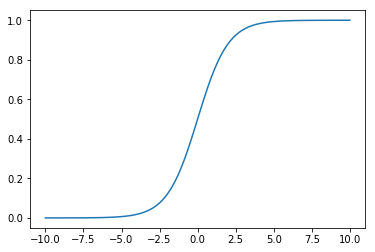

In [30]:
plt.plot(sample_z,sample_a)

### Sigmoid as an Operation

In [31]:
class Sigmoid(Operation):
   
    def __init__(self, z):

        # a is the input node
        super().__init__([z])

    def compute(self, z_val):
        return 1/(1+np.exp(-z_val))

##### Classification Example

In [32]:
from sklearn.datasets import make_blobs
data = make_blobs(n_samples = 50,n_features=2,centers=2,random_state=75)
data

(array([[  7.3402781 ,   9.36149154],
        [  9.13332743,   8.74906102],
        [  1.99243535,  -8.85885722],
        [  7.38443759,   7.72520389],
        [  7.97613887,   8.80878209],
        [  7.76974352,   9.50899462],
        [  8.3186688 ,  10.1026025 ],
        [  8.79588546,   7.28046702],
        [  9.81270381,   9.46968531],
        [  1.57961049,  -8.17089971],
        [  0.06441546,  -9.04982817],
        [  7.2075117 ,   7.04533624],
        [  9.10704928,   9.0272212 ],
        [  1.82921897,  -9.86956281],
        [  7.85036314,   7.986659  ],
        [  3.04605603,  -7.50486114],
        [  1.85582689,  -6.74473432],
        [  2.88603902,  -8.85261704],
        [ -1.20046211,  -9.55928542],
        [  2.00890845,  -9.78471782],
        [  7.68945113,   9.01706723],
        [  6.42356167,   8.33356412],
        [  8.15467319,   7.87489634],
        [  1.92000795,  -7.50953708],
        [  1.90073973,  -7.24386675],
        [  7.7605855 ,   7.05124418],
        [  6

In [33]:
type(data)

tuple

In [34]:
data[1]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1])

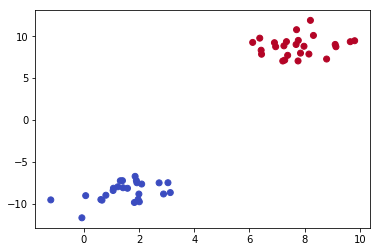

In [35]:
features = data[0]
labels = data[1]
plt.scatter(features[:,0],features[:,1], c=labels,cmap='coolwarm')

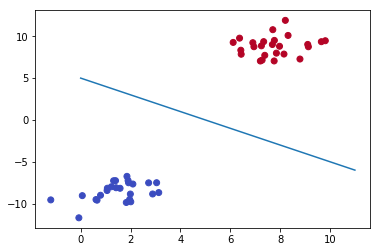

In [36]:
# DRAW A LINE THAT SEPERATES CLASSES
x = np.linspace(0,11,10)
y = -x + 5
plt.scatter(features[:,0],features[:,1],c=labels,cmap='coolwarm')
plt.plot(x,y)

## Defining the Perceptron

$$ y = mx + b $$

$$ y = -x + 5 $$

$$ f1 = mf2 + b , m=1$$

$$ f1 = -f2 + 5 $$

$$ f1 + f2 - 5 = 0 $$


## Convert to a Matrix Representation of Features

$$ w^Tx + b = 0 $$

$$   \Big(1, 1\Big)f - 5 = 0 $$

Then if the result is > 0 its label 1, if it is less than 0, it is label=0



### Example Point

Let's say we have the point f1=2 , f2=2 otherwise stated as (8,10). Then we have:

$$ 
\begin{pmatrix} 
1 , 1
\end{pmatrix} 
\begin{pmatrix} 
8 \\
10
\end{pmatrix} + 5 =  $$

$$ OR $$

$$ 
\begin{pmatrix} 
1 , 1
\end{pmatrix} 
\begin{pmatrix} 
2 \\
-10
\end{pmatrix} + 5 =  $$

In [37]:
np.array([1, 1]).dot(np.array([[8],[10]])) - 5   #Red Class

array([13])

In [38]:
np.array([1, 1]).dot(np.array([[2],[-10]])) - 5    #Blue Class

array([-13])

### Using an Example Session Graph

In [39]:
g = Graph()
g.set_as_default()

x = Placeholder()
w = Variable([1,1])
b = Variable(-5)

z = add(matmul(w,x),b)
a = Sigmoid(z)

sess = Session()

In [40]:
result = sess.run(operation=a,feed_dict={x:[8,10]})
result    #it belongs to Red Class

0.999997739675702

In [41]:
result = sess.run(operation=a,feed_dict={x:[2,-10]})
result   #it belongs to Blue Class

2.2603242979035746e-06